# `StableSpectralElements.jl` - 3D Euler example using entropy-stable  discretization

First, let's load the packages used in this example.

In [1]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, TimerOutputs, StaticArrays, BenchmarkTools

[ Info: Precompiling StableSpectralElements [fb992021-99c7-4c2d-a14b-5e48ac4045b2]


We will be solving the three-dimensional compressible Euler equations, which are a hyperbolic system of conservation laws given by
$$
\begin{aligned}
\partial_t \rho(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) &= 0,\\
\partial_t ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t) \otimes \boldsymbol{V}(\boldsymbol{x},t) + P(\boldsymbol{x},t)\boldsymbol{I}) &= \boldsymbol{0},\\
\partial_t E(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ((E(\boldsymbol{x},t) + P(\boldsymbol{x},t))\boldsymbol{V}(\boldsymbol{x},t)) &= 0,
\end{aligned}
$$
with 
$$
 P(\boldsymbol{x},t) = (\gamma - 1)\big(E(\boldsymbol{x},t) - \tfrac{1}{2} \rho(\boldsymbol{x},t) \lVert \boldsymbol{V}(\boldsymbol{x},t) \rVert^2 \big),
$$
where $\gamma = 1.4$ is the specific heat ratio. The initial condition is a propagating density wave on the domain $\Omega = (0,2)^3$ with periodic boundary conditions.

In [5]:
L = 2.0
T = L
Ω = ((0.0,L),(0.0,L),(0.0,L))

conservation_law = EulerEquations{3}(1.4)
exact_solution = EulerPeriodicTest(conservation_law);

EulerPeriodicTest{3}(1.4, 0.2, 5)

Let's discretize the above problem using a `ModalMulti` discretization of degree $p = 3$ on an isoparametrically warped tetrahedral mesh with $M = 4$ edges in each direction. We will use an entropy-conservative flux-differencing scheme employing [Ranocha's two-point flux](https://link.springer.com/chapter/10.1007/978-3-030-39647-3_42). A conservative-curl formulation (see [Chan and Wilcox, 2018](https://arxiv.org/abs/1805.10934)) is used to impose the discrete metric identities.

In [6]:
p = 3
M = 4

form = FluxDifferencingForm(inviscid_numerical_flux=EntropyConservativeNumericalFlux())

reference_approximation = ReferenceApproximation(ModalMulti(p), Tet(), mapping_degree=p)

uniform_mesh = uniform_periodic_mesh(reference_approximation, Ω, (M,M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, ChanWarping(1/16, (L,L,L)))

spatial_discretization = SpatialDiscretization(mesh, reference_approximation,
    ChanWilcoxMetrics())

results_path = save_project(conservation_law,
    spatial_discretization, exact_solution, form, (0.0, T),
    "results/euler_periodic_3d/", overwrite=true, clear=true);

ode = semidiscretize(conservation_law, spatial_discretization, 
    exact_solution, form, (0.0, T), parallelism=Serial());

We'll now plot the initial data on the mesh. Shown below is the output from ParaView.

In [12]:
postprocess_vtk(spatial_discretization, string(results_path,
    "initial_data.vtu"), ode.u0, variable_name="Density");

![800x600](figures/euler_3d_initial_condition.png)

The resulting system of ordinary differential equations can then be solved as usual using OrdinaryDiffEq.jl's `solve` function.

In [13]:
N_t = 25*M*(p+1)
reset_timer!()
sol = solve(ode, DP8(), adaptive=false, dt=T/N_t, save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), floor(Int, N_t/50)))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:             332s /  96.2%           17.2GiB /  93.5%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 semi-disc. residual    6.50k     320s  100.0%  49.2ms   16.1GiB  100.0%  2.53MiB
   time deriv.          2.50M     270s   84.5%   108μs     0.00B    0.0%    0.00B
   nodal values         2.50M    48.8s   15.3%  19.6μs   16.1GiB  100.0%  6.75KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in each conservative variable (i.e. $\rho$, $\rho V_1$, $\rho V_2$, $\rho V_3$, and $E$) can be computed as follows.

In [14]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T))

L2 error:
[0.047852224439598585, 0.05477558912851541, 0.05628223436549405, 0.05267976222866462, 0.1326607181519703]


We'll check that the scheme is indeed (entropy) conservative by plotting the evolution of the integrated conservative variables and entropy.

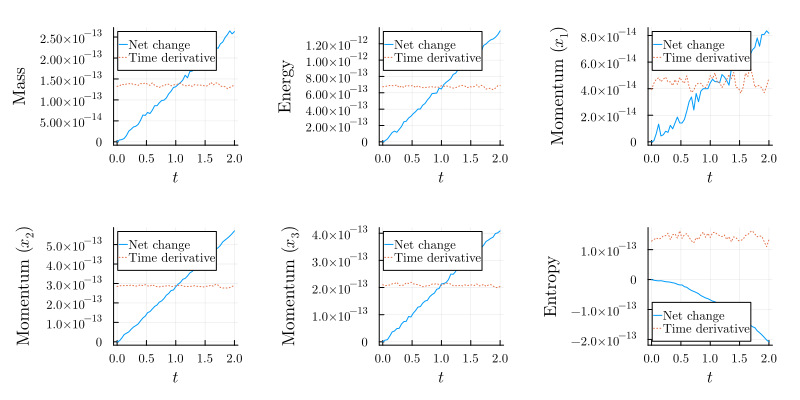

In [16]:
conservation = analyze(PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization),
    load_time_steps(results_path), normalize=false)
entropy_analysis = EntropyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
entropy_results = analyze(entropy_analysis, load_time_steps(results_path))

mass = plot(conservation, ylabel="Mass", 1)
xmom = plot(conservation, ylabel="Momentum (\$x_1\$)", 2)
ymom = plot(conservation, ylabel="Momentum (\$x_2\$)", 3)
zmom = plot(conservation, ylabel="Momentum (\$x_3\$)", 4)
energy = plot(conservation, ylabel="Energy", 5)
entropy = plot(entropy_results, ylabel="Entropy")

plot(mass, energy, xmom, ymom, zmom, entropy, size=(800,400), margin=5mm, fmt=:png)

We can finally plot the evolution of the integrated mathematical entropy $\int_{\Omega} S(U(\boldsymbol{x},t)) \, \mathrm{d} \boldsymbol{x}$, where $S(U(\boldsymbol{x},t)) = - \tfrac{1}{1-\gamma}\rho(\boldsymbol{x},t) \ln(p(\boldsymbol{x},t)/\rho(\boldsymbol{x},t)^\gamma) $, again using the scheme's collocated LGL quadrature rule. Notice that the scheme dissipates entropy, as expected.

We can now visualize the density field as a `.vtu` file, for example, in ParaView.

In [17]:
for i in eachindex(sol.u)
    postprocess_vtk(spatial_discretization, string(results_path,
        "solution_",i,".vtu"), sol.u[i], variable_name="Density")
end